- Hatmap
- Melhorar o plot de imagens
- Propor algo novo

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy 
import cv2
from torch.autograd import Variable
import random
import shutil, sys
import pandas as pd
from PIL import Image
from PIL import ImageFile
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
#model_name = "densenet"

# Number of classes in the dataset
#num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for


# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

#num_epochs = 500

In [3]:
test = 2

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val', 'test']}

# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                    batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# trans = ['train','val','test']
# categories = ['train','val','test']

class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#device.reset()

Initializing Datasets and Dataloaders...


In [5]:
# Path to data
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

len_train_dir = len([iq for iq in os.scandir(train_dir+'covid/')]) + len([iq for iq in os.scandir(train_dir+'normal/')]) + len([iq for iq in os.scandir(train_dir+'pneumonia/')])
len_test_dir = len([iq for iq in os.scandir(test_dir+'covid/')]) + len([iq for iq in os.scandir(test_dir+'normal/')]) + len([iq for iq in os.scandir(test_dir+'pneumonia/')])
len_val_dir = len([iq for iq in os.scandir(val_dir+'covid/')]) + len([iq for iq in os.scandir(val_dir+'normal/')]) + len([iq for iq in os.scandir(val_dir+'pneumonia/')])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)

print("pneumonia : ", len_normal)

print("covid : ", len_pneumonia)

print("-"*20)

print('Train, test, validation')

print("-"*20)

print("len_train_dir : ", len_train_dir)

print("len_test_dir : ", len_test_dir)

print("len_val_dir : ", len_val_dir)



Files per classes
----------------------------------------
normal :  4023
pneumonia :  4035
covid :  4105
--------------------
Train, test, validation
--------------------
len_train_dir :  9632
len_test_dir :  31
len_val_dir :  2409


In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, 
                model_name, lr, batch_size, opt_name, crt_name):
    since = time.time()
    is_inception = False
    
    #tensorboard
    writer = SummaryWriter(f'runs/dg_{model_name}_lr={lr}_epoch={num_epochs}_batch_size={batch_size}')
    step = 0

    val_acc_history = []
    val_loss_history = []
    
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            writer.add_scalar('training loss', loss, global_step=step)
            writer.add_scalar('training accuracy', epoch_acc, global_step=step)
            step += 1
            
            #only to plot the graph
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()
        
        
    time_elapsed = time.time() - since
    print()
    print('#'*30)
    print('------ Summary ------')
    print(f'model -> {_model}')
    print(f'epochs -> {_epochs}')
    print(f'lr -> {_lrs}')
    print(f'batch size -> {_batch}')
    print(f'optimizer -> {opt_name}'), 
    print(f'criteriun -> {crt_name}')
    print()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('#'*30)
    
    plt.figure(figsize=(13, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_acc_history, label="Validation Accuracy")
    plt.plot(train_acc_history, label="Validation Loss")
    plt.title('Accuracy and Loss in Validation Dataset')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_loss_history, label="val_loss_history")
    plt.plot(train_loss_history, label="train_loss_history")
    plt.legend()
    plt.tight_layout()
    plt.savefig('hist_'+_model+'_opt_'+opt_name+'_crt_'+crt_name+'.png')
    plt.show()

    print()

    print('==== END ====')


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [7]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [10]:
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('cm_'+title+'.png')


==== INITIALIZING WITH PARAMETERS: ====
model -> resnet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.5639 Acc: 0.8018
val Loss: 0.2995 Acc: 0.9236

Epoch 1/299
----------
train Loss: 0.3578 Acc: 0.8825
val Loss: 0.2366 Acc: 0.9336

Epoch 2/299
----------
train Loss: 0.3182 Acc: 0.8924
val Loss: 0.2096 Acc: 0.9344

Epoch 3/299
----------
train Loss: 0.3009 Acc: 0.8944
val Loss: 0.1788 Acc: 0.9481

Epoch 4/299
----------
train Loss: 0.2828 Acc: 0.8969
val Loss: 0.1700 Acc: 0.9481

Epoch 5/299
----------
train Loss: 0.2695 Acc: 0.9031
val Loss: 0.2404 Acc: 0.9099

Epoch 6/299
----------
train Loss: 0.2618 Acc: 0.9061
val Loss: 0.1781 Acc: 0.9381

Epoch 7/299
----------
train Loss: 0.2551 Acc: 0.9081
val Loss: 0.1512 Acc: 0.9556

Epoch 8/299
----------
train Loss: 0.2483 Acc: 0.9097
val Loss: 0.3041 Acc: 0.8751

Epoch 9/299
-----

train Loss: 0.1973 Acc: 0.9243
val Loss: 0.1102 Acc: 0.9585

Epoch 94/299
----------
train Loss: 0.1891 Acc: 0.9290
val Loss: 0.1261 Acc: 0.9510

Epoch 95/299
----------
train Loss: 0.1893 Acc: 0.9288
val Loss: 0.1207 Acc: 0.9535

Epoch 96/299
----------
train Loss: 0.1945 Acc: 0.9278
val Loss: 0.1041 Acc: 0.9577

Epoch 97/299
----------
train Loss: 0.1787 Acc: 0.9342
val Loss: 0.1119 Acc: 0.9564

Epoch 98/299
----------
train Loss: 0.1968 Acc: 0.9289
val Loss: 0.1127 Acc: 0.9556

Epoch 99/299
----------
train Loss: 0.1849 Acc: 0.9303
val Loss: 0.1184 Acc: 0.9556

Epoch 100/299
----------
train Loss: 0.1853 Acc: 0.9333
val Loss: 0.1368 Acc: 0.9489

Epoch 101/299
----------
train Loss: 0.1848 Acc: 0.9320
val Loss: 0.1425 Acc: 0.9452

Epoch 102/299
----------
train Loss: 0.1864 Acc: 0.9255
val Loss: 0.1149 Acc: 0.9577

Epoch 103/299
----------
train Loss: 0.1856 Acc: 0.9352
val Loss: 0.1867 Acc: 0.9257

Epoch 104/299
----------
train Loss: 0.1861 Acc: 0.9303
val Loss: 0.1876 Acc: 0.9261


val Loss: 0.1138 Acc: 0.9552

Epoch 189/299
----------
train Loss: 0.1812 Acc: 0.9331
val Loss: 0.1612 Acc: 0.9365

Epoch 190/299
----------
train Loss: 0.1786 Acc: 0.9293
val Loss: 0.2700 Acc: 0.8917

Epoch 191/299
----------
train Loss: 0.1803 Acc: 0.9341
val Loss: 0.1217 Acc: 0.9502

Epoch 192/299
----------
train Loss: 0.1868 Acc: 0.9296
val Loss: 0.1361 Acc: 0.9456

Epoch 193/299
----------
train Loss: 0.1937 Acc: 0.9261
val Loss: 0.1144 Acc: 0.9527

Epoch 194/299
----------
train Loss: 0.1814 Acc: 0.9306
val Loss: 0.1565 Acc: 0.9377

Epoch 195/299
----------
train Loss: 0.1854 Acc: 0.9315
val Loss: 0.1166 Acc: 0.9531

Epoch 196/299
----------
train Loss: 0.1802 Acc: 0.9340
val Loss: 0.1090 Acc: 0.9539

Epoch 197/299
----------
train Loss: 0.1836 Acc: 0.9313
val Loss: 0.1332 Acc: 0.9452

Epoch 198/299
----------
train Loss: 0.1782 Acc: 0.9308
val Loss: 0.1114 Acc: 0.9556

Epoch 199/299
----------
train Loss: 0.1818 Acc: 0.9328
val Loss: 0.1141 Acc: 0.9572

Epoch 200/299
----------

train Loss: 0.1723 Acc: 0.9349
val Loss: 0.1161 Acc: 0.9531

Epoch 285/299
----------
train Loss: 0.1675 Acc: 0.9363
val Loss: 0.1780 Acc: 0.9311

Epoch 286/299
----------
train Loss: 0.1754 Acc: 0.9327
val Loss: 0.1122 Acc: 0.9548

Epoch 287/299
----------
train Loss: 0.1799 Acc: 0.9333
val Loss: 0.1168 Acc: 0.9527

Epoch 288/299
----------
train Loss: 0.1845 Acc: 0.9328
val Loss: 0.1461 Acc: 0.9423

Epoch 289/299
----------
train Loss: 0.1746 Acc: 0.9327
val Loss: 0.1199 Acc: 0.9498

Epoch 290/299
----------
train Loss: 0.1740 Acc: 0.9310
val Loss: 0.1223 Acc: 0.9489

Epoch 291/299
----------
train Loss: 0.1755 Acc: 0.9336
val Loss: 0.1183 Acc: 0.9518

Epoch 292/299
----------
train Loss: 0.1860 Acc: 0.9305
val Loss: 0.3871 Acc: 0.8497

Epoch 293/299
----------
train Loss: 0.1746 Acc: 0.9342
val Loss: 0.2447 Acc: 0.9045

Epoch 294/299
----------
train Loss: 0.1744 Acc: 0.9337
val Loss: 0.1093 Acc: 0.9572

Epoch 295/299
----------
train Loss: 0.1734 Acc: 0.9369
val Loss: 0.1137 Acc: 0

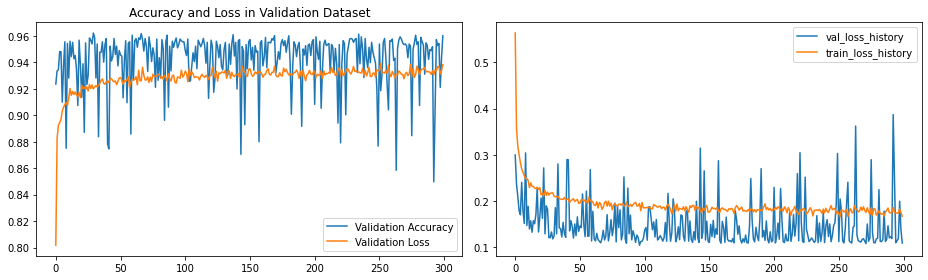


==== END ====
[[783   0   8]
 [  2 761  36]
 [  2  43 774]]

Sensitivity or recall total
0.9622249896222499

Sensitivity or recall per classes
[0.98988622 0.95244055 0.94505495]

Precision
[0.99491741 0.94651741 0.94621027]

F1 Score
[0.99239544 0.94946974 0.94563225]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> resnet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 2

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -86.3078 Acc: 0.4387
val Loss: -173.3658 Acc: 0.3753

Epoch 1/299
----------
train Loss: -261.1668 Acc: 0.4685
val Loss: -349.1338 Acc: 0.4209

Epoch 2/299
----------
train Loss: -436.0430 Acc: 0.4223
val Loss: -512.2901 Acc: 0.4384

Epoch 3/299
----------
train Loss: -611.2082 Acc: 0.4215
val Loss: -691.3469 Acc: 0.4251

Epoch 4/299
----------
train Loss: -786.1817 Acc: 0.4098
val Loss: -840.9140 Acc: 0.3844

Epoch 5/299
--

val Loss: -14447.0185 Acc: 0.4313

Epoch 82/299
----------
train Loss: -14426.1857 Acc: 0.4143
val Loss: -14504.0404 Acc: 0.3885

Epoch 83/299
----------
train Loss: -14604.9077 Acc: 0.4115
val Loss: -14542.1153 Acc: 0.4288

Epoch 84/299
----------
train Loss: -14779.8543 Acc: 0.4139
val Loss: -14702.2533 Acc: 0.3885

Epoch 85/299
----------
train Loss: -14957.4004 Acc: 0.4175
val Loss: -14658.3013 Acc: 0.4193

Epoch 86/299
----------
train Loss: -15134.0603 Acc: 0.4187
val Loss: -15143.7999 Acc: 0.3466

Epoch 87/299
----------
train Loss: -15306.4973 Acc: 0.4146
val Loss: -15036.1867 Acc: 0.4081

Epoch 88/299
----------
train Loss: -15474.4443 Acc: 0.4123
val Loss: -15205.1104 Acc: 0.4230

Epoch 89/299
----------
train Loss: -15653.9022 Acc: 0.4145
val Loss: -15468.9701 Acc: 0.4242

Epoch 90/299
----------
train Loss: -15828.5740 Acc: 0.4125
val Loss: -15441.4776 Acc: 0.3935

Epoch 91/299
----------
train Loss: -16000.9382 Acc: 0.4135
val Loss: -15843.5115 Acc: 0.3728

Epoch 92/299
--

train Loss: -29299.7639 Acc: 0.4178
val Loss: -28833.1607 Acc: 0.4296

Epoch 168/299
----------
train Loss: -29465.0621 Acc: 0.4156
val Loss: -29565.0252 Acc: 0.4176

Epoch 169/299
----------
train Loss: -29645.2287 Acc: 0.4158
val Loss: -28945.4479 Acc: 0.3856

Epoch 170/299
----------
train Loss: -29824.1749 Acc: 0.4172
val Loss: -29180.3572 Acc: 0.4255

Epoch 171/299
----------
train Loss: -30004.0178 Acc: 0.4143
val Loss: -29852.6154 Acc: 0.4263

Epoch 172/299
----------
train Loss: -30176.1541 Acc: 0.4142
val Loss: -29972.5087 Acc: 0.4317

Epoch 173/299
----------
train Loss: -30347.8159 Acc: 0.4152
val Loss: -30820.4788 Acc: 0.4209

Epoch 174/299
----------
train Loss: -30524.5793 Acc: 0.4111
val Loss: -29844.5075 Acc: 0.3881

Epoch 175/299
----------
train Loss: -30692.6590 Acc: 0.4138
val Loss: -30663.1856 Acc: 0.4425

Epoch 176/299
----------
train Loss: -30882.2570 Acc: 0.4156
val Loss: -30034.4231 Acc: 0.3782

Epoch 177/299
----------
train Loss: -31056.3441 Acc: 0.4120
val 

val Loss: -43523.7255 Acc: 0.4425

Epoch 253/299
----------
train Loss: -44342.5186 Acc: 0.4161
val Loss: -44253.0139 Acc: 0.3591

Epoch 254/299
----------
train Loss: -44511.1018 Acc: 0.4132
val Loss: -43836.0048 Acc: 0.4355

Epoch 255/299
----------
train Loss: -44678.8964 Acc: 0.4123
val Loss: -44307.2126 Acc: 0.4259

Epoch 256/299
----------
train Loss: -44870.9776 Acc: 0.4152
val Loss: -44177.2456 Acc: 0.3661

Epoch 257/299
----------
train Loss: -45038.6728 Acc: 0.4146
val Loss: -44479.0488 Acc: 0.4201

Epoch 258/299
----------
train Loss: -45217.8724 Acc: 0.4157
val Loss: -44080.2352 Acc: 0.3935

Epoch 259/299
----------
train Loss: -45395.5971 Acc: 0.4121
val Loss: -44300.8286 Acc: 0.3790

Epoch 260/299
----------
train Loss: -45577.3427 Acc: 0.4159
val Loss: -45000.9499 Acc: 0.4392

Epoch 261/299
----------
train Loss: -45736.6098 Acc: 0.4097
val Loss: -44956.5244 Acc: 0.4043

Epoch 262/299
----------
train Loss: -45919.7549 Acc: 0.4136
val Loss: -45695.9304 Acc: 0.4035

Epoch

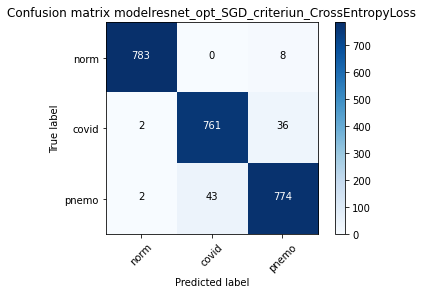

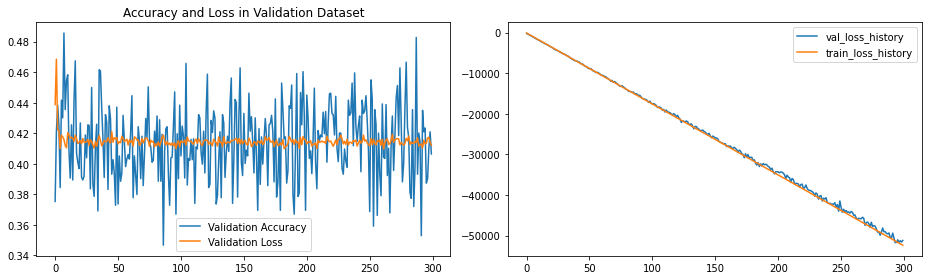


==== END ====
[[791   0   0]
 [420 379   0]
 [807  12   0]]

Sensitivity or recall total
0.48567870485678705

Sensitivity or recall per classes
[1.   0.47 0.  ]

Precision
[0.39 0.97 0.  ]

F1 Score
[0.56 0.64 0.  ]
Confusion matrix, without normalization


/home/jimi/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



==== INITIALIZING WITH PARAMETERS: ====
model -> resnet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.6248 Acc: 0.7974
val Loss: 0.3737 Acc: 0.9095

Epoch 1/299
----------
train Loss: 0.4062 Acc: 0.8745
val Loss: 0.2584 Acc: 0.9315

Epoch 2/299
----------
train Loss: 0.3418 Acc: 0.8879
val Loss: 0.2593 Acc: 0.9186

Epoch 3/299
----------
train Loss: 0.3218 Acc: 0.8884
val Loss: 0.2001 Acc: 0.9444

Epoch 4/299
----------
train Loss: 0.2967 Acc: 0.8988
val Loss: 0.1880 Acc: 0.9406

Epoch 5/299
----------
train Loss: 0.2817 Acc: 0.9010
val Loss: 0.1857 Acc: 0.9402

Epoch 6/299
----------
train Loss: 0.2764 Acc: 0.8990
val Loss: 0.2099 Acc: 0.9278

Epoch 7/299
----------
train Loss: 0.2681 Acc: 0.9064
val Loss: 0.1653 Acc: 0.9448

Epoch 8/299
----------
train Loss: 0.2572 Acc: 0.9077
val Loss: 0.1839 Acc: 0.9344

Epoch 9/299
-----

train Loss: 0.1852 Acc: 0.9298
val Loss: 0.1138 Acc: 0.9568

Epoch 94/299
----------
train Loss: 0.1823 Acc: 0.9259
val Loss: 0.1830 Acc: 0.9261

Epoch 95/299
----------
train Loss: 0.1840 Acc: 0.9300
val Loss: 0.1094 Acc: 0.9593

Epoch 96/299
----------
train Loss: 0.1943 Acc: 0.9281
val Loss: 0.1426 Acc: 0.9423

Epoch 97/299
----------
train Loss: 0.1868 Acc: 0.9304
val Loss: 0.1273 Acc: 0.9514

Epoch 98/299
----------
train Loss: 0.1824 Acc: 0.9330
val Loss: 0.1504 Acc: 0.9431

Epoch 99/299
----------
train Loss: 0.1783 Acc: 0.9332
val Loss: 0.1215 Acc: 0.9514

Epoch 100/299
----------
train Loss: 0.1883 Acc: 0.9283
val Loss: 0.1288 Acc: 0.9489

Epoch 101/299
----------
train Loss: 0.1992 Acc: 0.9261
val Loss: 0.1561 Acc: 0.9394

Epoch 102/299
----------
train Loss: 0.1870 Acc: 0.9304
val Loss: 0.1085 Acc: 0.9597

Epoch 103/299
----------
train Loss: 0.1963 Acc: 0.9241
val Loss: 0.1143 Acc: 0.9572

Epoch 104/299
----------
train Loss: 0.1876 Acc: 0.9295
val Loss: 0.1125 Acc: 0.9593


val Loss: 0.1116 Acc: 0.9548

Epoch 189/299
----------
train Loss: 0.1720 Acc: 0.9359
val Loss: 0.1194 Acc: 0.9560

Epoch 190/299
----------
train Loss: 0.1760 Acc: 0.9360
val Loss: 0.2085 Acc: 0.9153

Epoch 191/299
----------
train Loss: 0.1800 Acc: 0.9329
val Loss: 0.1117 Acc: 0.9589

Epoch 192/299
----------
train Loss: 0.1721 Acc: 0.9346
val Loss: 0.2479 Acc: 0.9012

Epoch 193/299
----------
train Loss: 0.1794 Acc: 0.9326
val Loss: 0.1058 Acc: 0.9568

Epoch 194/299
----------
train Loss: 0.1793 Acc: 0.9339
val Loss: 0.1107 Acc: 0.9560

Epoch 195/299
----------
train Loss: 0.1708 Acc: 0.9362
val Loss: 0.1180 Acc: 0.9523

Epoch 196/299
----------
train Loss: 0.1822 Acc: 0.9336
val Loss: 0.1043 Acc: 0.9593

Epoch 197/299
----------
train Loss: 0.1822 Acc: 0.9343
val Loss: 0.2618 Acc: 0.8929

Epoch 198/299
----------
train Loss: 0.1743 Acc: 0.9345
val Loss: 0.1778 Acc: 0.9311

Epoch 199/299
----------
train Loss: 0.1715 Acc: 0.9342
val Loss: 0.1054 Acc: 0.9585

Epoch 200/299
----------

train Loss: 0.1809 Acc: 0.9300
val Loss: 0.2368 Acc: 0.9045

Epoch 285/299
----------
train Loss: 0.1786 Acc: 0.9332
val Loss: 0.1357 Acc: 0.9481

Epoch 286/299
----------
train Loss: 0.1783 Acc: 0.9337
val Loss: 0.1531 Acc: 0.9365

Epoch 287/299
----------
train Loss: 0.1747 Acc: 0.9335
val Loss: 0.1608 Acc: 0.9365

Epoch 288/299
----------
train Loss: 0.1718 Acc: 0.9358
val Loss: 0.1574 Acc: 0.9348

Epoch 289/299
----------
train Loss: 0.1712 Acc: 0.9359
val Loss: 0.1108 Acc: 0.9564

Epoch 290/299
----------
train Loss: 0.1695 Acc: 0.9379
val Loss: 0.1081 Acc: 0.9560

Epoch 291/299
----------
train Loss: 0.1720 Acc: 0.9339
val Loss: 0.1407 Acc: 0.9444

Epoch 292/299
----------
train Loss: 0.1776 Acc: 0.9351
val Loss: 0.1052 Acc: 0.9581

Epoch 293/299
----------
train Loss: 0.1723 Acc: 0.9345
val Loss: 0.1881 Acc: 0.9278

Epoch 294/299
----------
train Loss: 0.1787 Acc: 0.9340
val Loss: 0.1669 Acc: 0.9311

Epoch 295/299
----------
train Loss: 0.1713 Acc: 0.9331
val Loss: 0.1056 Acc: 0

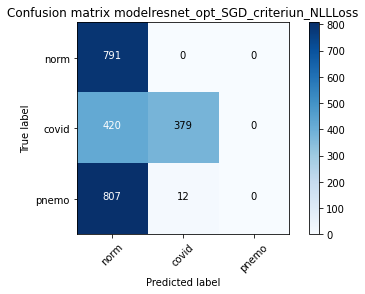

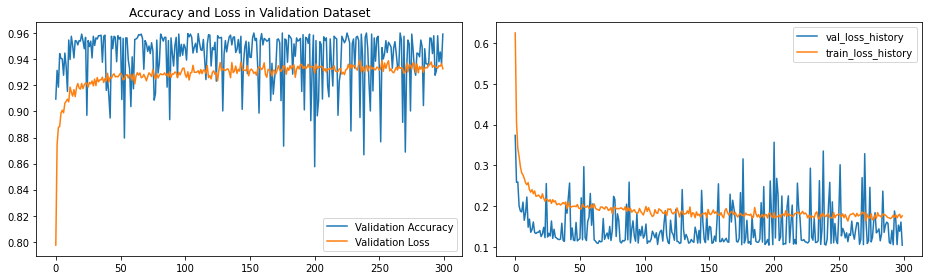


==== END ====
[[782   3   6]
 [  2 762  35]
 [  3  47 769]]

Sensitivity or recall total
0.9601494396014943

Sensitivity or recall per classes
[0.99 0.95 0.94]

Precision
[0.99 0.94 0.95]

F1 Score
[0.99 0.95 0.94]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> resnet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 2

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -24.0513 Acc: 0.3695
val Loss: -48.0350 Acc: 0.3508

Epoch 1/299
----------
train Loss: -72.3945 Acc: 0.3692
val Loss: -93.9984 Acc: 0.3483

Epoch 2/299
----------
train Loss: -120.6336 Acc: 0.3518
val Loss: -142.1206 Acc: 0.3445

Epoch 3/299
----------
train Loss: -168.8832 Acc: 0.3524
val Loss: -192.7533 Acc: 0.3470

Epoch 4/299
----------
train Loss: -217.2120 Acc: 0.3545
val Loss: -235.8140 Acc: 0.3620

Epoch 5/299
----------
train Loss: -265.6029 Acc: 0.3648
val Loss: -281

train Loss: -4039.4964 Acc: 0.3901
val Loss: -4068.7351 Acc: 0.3836

Epoch 84/299
----------
train Loss: -4088.1036 Acc: 0.3930
val Loss: -4081.6462 Acc: 0.4218

Epoch 85/299
----------
train Loss: -4136.3432 Acc: 0.3950
val Loss: -4172.9582 Acc: 0.4031

Epoch 86/299
----------
train Loss: -4184.9053 Acc: 0.3966
val Loss: -4128.1501 Acc: 0.3881

Epoch 87/299
----------
train Loss: -4233.3589 Acc: 0.3953
val Loss: -4194.7816 Acc: 0.4072

Epoch 88/299
----------
train Loss: -4281.2403 Acc: 0.3968
val Loss: -4218.0611 Acc: 0.3861

Epoch 89/299
----------
train Loss: -4330.4701 Acc: 0.4007
val Loss: -4291.7805 Acc: 0.3379

Epoch 90/299
----------
train Loss: -4378.6202 Acc: 0.4055
val Loss: -4337.9433 Acc: 0.4442

Epoch 91/299
----------
train Loss: -4426.5758 Acc: 0.4050
val Loss: -4295.1217 Acc: 0.3902

Epoch 92/299
----------
train Loss: -4475.4627 Acc: 0.4081
val Loss: -4398.5339 Acc: 0.3657

Epoch 93/299
----------
train Loss: -4523.9611 Acc: 0.4042
val Loss: -4453.8810 Acc: 0.3819

E

val Loss: -8225.8411 Acc: 0.4072

Epoch 171/299
----------
train Loss: -8297.1655 Acc: 0.4102
val Loss: -8197.3420 Acc: 0.4408

Epoch 172/299
----------
train Loss: -8345.3766 Acc: 0.4055
val Loss: -8174.4227 Acc: 0.3628

Epoch 173/299
----------
train Loss: -8394.6668 Acc: 0.4081
val Loss: -8250.7135 Acc: 0.3811

Epoch 174/299
----------
train Loss: -8442.0805 Acc: 0.4075
val Loss: -8344.9812 Acc: 0.4438

Epoch 175/299
----------
train Loss: -8490.6271 Acc: 0.4089
val Loss: -8497.6578 Acc: 0.4247

Epoch 176/299
----------
train Loss: -8539.0645 Acc: 0.4105
val Loss: -8268.1783 Acc: 0.3537

Epoch 177/299
----------
train Loss: -8587.3849 Acc: 0.4046
val Loss: -8544.6138 Acc: 0.4284

Epoch 178/299
----------
train Loss: -8635.6023 Acc: 0.4056
val Loss: -8605.3953 Acc: 0.4433

Epoch 179/299
----------
train Loss: -8682.7290 Acc: 0.4059
val Loss: -8400.2601 Acc: 0.3836

Epoch 180/299
----------
train Loss: -8731.4278 Acc: 0.4065
val Loss: -8631.8664 Acc: 0.4022

Epoch 181/299
----------
t

train Loss: -12459.7685 Acc: 0.4170
val Loss: -12333.3373 Acc: 0.4379

Epoch 258/299
----------
train Loss: -12507.3449 Acc: 0.4129
val Loss: -12510.5593 Acc: 0.4417

Epoch 259/299
----------
train Loss: -12556.5597 Acc: 0.4160
val Loss: -12419.4979 Acc: 0.3757

Epoch 260/299
----------
train Loss: -12604.4133 Acc: 0.4157
val Loss: -12520.6276 Acc: 0.4010

Epoch 261/299
----------
train Loss: -12652.7510 Acc: 0.4158
val Loss: -12497.4609 Acc: 0.4018

Epoch 262/299
----------
train Loss: -12700.2411 Acc: 0.4143
val Loss: -12510.7900 Acc: 0.3645

Epoch 263/299
----------
train Loss: -12751.0850 Acc: 0.4199
val Loss: -12769.1708 Acc: 0.4255

Epoch 264/299
----------
train Loss: -12799.6407 Acc: 0.4159
val Loss: -12991.1807 Acc: 0.4222

Epoch 265/299
----------
train Loss: -12847.1930 Acc: 0.4176
val Loss: -12664.9826 Acc: 0.3836

Epoch 266/299
----------
train Loss: -12894.4565 Acc: 0.4177
val Loss: -12627.0297 Acc: 0.4230

Epoch 267/299
----------
train Loss: -12943.1203 Acc: 0.4123
val 

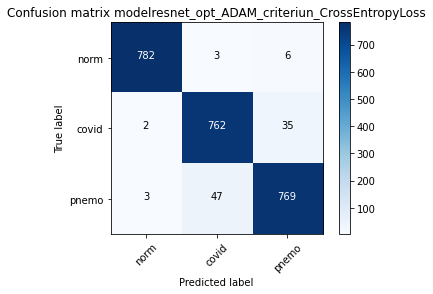

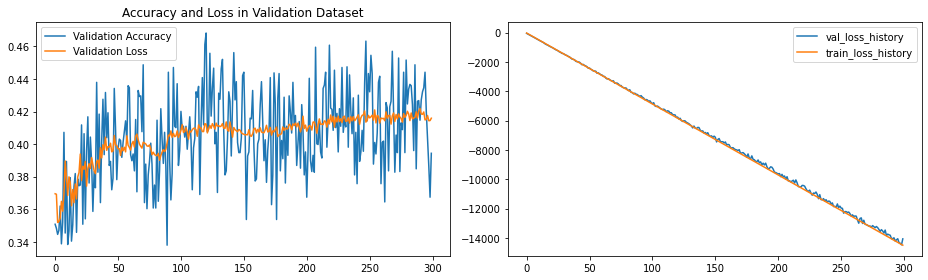


==== END ====
[[791   0   0]
 [462 337   0]
 [811   8   0]]

Sensitivity or recall total
0.46824408468244083

Sensitivity or recall per classes
[1.   0.42 0.  ]

Precision
[0.38 0.98 0.  ]

F1 Score
[0.55 0.59 0.  ]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> resnet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.6411 Acc: 0.7789
val Loss: 0.3750 Acc: 0.9157

Epoch 1/299
----------
train Loss: 0.3998 Acc: 0.8739
val Loss: 0.2781 Acc: 0.9224

Epoch 2/299
----------
train Loss: 0.3445 Acc: 0.8887
val Loss: 0.2111 Acc: 0.9440

Epoch 3/299
----------
train Loss: 0.3157 Acc: 0.8893
val Loss: 0.2584 Acc: 0.9062

Epoch 4/299
----------
train Loss: 0.2914 Acc: 0.9007
val Loss: 0.1838 Acc: 0.9494

Epoch 5/299
----------
train Loss: 0.2815 Acc: 0.9021
val Loss: 0.2031 Acc: 0.9257

Epoch 6/299


train Loss: 0.1865 Acc: 0.9305
val Loss: 0.1104 Acc: 0.9577

Epoch 91/299
----------
train Loss: 0.1780 Acc: 0.9344
val Loss: 0.1835 Acc: 0.9228

Epoch 92/299
----------
train Loss: 0.1988 Acc: 0.9243
val Loss: 0.1090 Acc: 0.9601

Epoch 93/299
----------
train Loss: 0.1770 Acc: 0.9363
val Loss: 0.1256 Acc: 0.9535

Epoch 94/299
----------
train Loss: 0.1874 Acc: 0.9304
val Loss: 0.1718 Acc: 0.9303

Epoch 95/299
----------
train Loss: 0.1863 Acc: 0.9273
val Loss: 0.1532 Acc: 0.9394

Epoch 96/299
----------
train Loss: 0.1840 Acc: 0.9311
val Loss: 0.1810 Acc: 0.9269

Epoch 97/299
----------
train Loss: 0.1884 Acc: 0.9276
val Loss: 0.1168 Acc: 0.9552

Epoch 98/299
----------
train Loss: 0.1912 Acc: 0.9296
val Loss: 0.1050 Acc: 0.9601

Epoch 99/299
----------
train Loss: 0.1915 Acc: 0.9255
val Loss: 0.1352 Acc: 0.9473

Epoch 100/299
----------
train Loss: 0.1817 Acc: 0.9355
val Loss: 0.1956 Acc: 0.9195

Epoch 101/299
----------
train Loss: 0.1928 Acc: 0.9275
val Loss: 0.1198 Acc: 0.9539

Ep

train Loss: 0.1801 Acc: 0.9347
val Loss: 0.2694 Acc: 0.8917

Epoch 187/299
----------
train Loss: 0.1843 Acc: 0.9297
val Loss: 0.1237 Acc: 0.9552

Epoch 188/299
----------
train Loss: 0.1791 Acc: 0.9302
val Loss: 0.2591 Acc: 0.8941

Epoch 189/299
----------
train Loss: 0.1754 Acc: 0.9323
val Loss: 0.2575 Acc: 0.8966

Epoch 190/299
----------
train Loss: 0.1785 Acc: 0.9325
val Loss: 0.1118 Acc: 0.9572

Epoch 191/299
----------
train Loss: 0.1890 Acc: 0.9330
val Loss: 0.1406 Acc: 0.9469

Epoch 192/299
----------
train Loss: 0.1758 Acc: 0.9318
val Loss: 0.1106 Acc: 0.9564

Epoch 193/299
----------
train Loss: 0.1785 Acc: 0.9358
val Loss: 0.1138 Acc: 0.9539

Epoch 194/299
----------
train Loss: 0.1743 Acc: 0.9322
val Loss: 0.1313 Acc: 0.9469

Epoch 195/299
----------
train Loss: 0.1753 Acc: 0.9322
val Loss: 0.1475 Acc: 0.9415

Epoch 196/299
----------
train Loss: 0.1855 Acc: 0.9291
val Loss: 0.2904 Acc: 0.8821

Epoch 197/299
----------
train Loss: 0.1773 Acc: 0.9325
val Loss: 0.1074 Acc: 0

val Loss: 0.1165 Acc: 0.9556

Epoch 282/299
----------
train Loss: 0.1675 Acc: 0.9358
val Loss: 0.2690 Acc: 0.8929

Epoch 283/299
----------
train Loss: 0.1802 Acc: 0.9323
val Loss: 0.1059 Acc: 0.9568

Epoch 284/299
----------
train Loss: 0.1748 Acc: 0.9346
val Loss: 0.1358 Acc: 0.9448

Epoch 285/299
----------
train Loss: 0.1737 Acc: 0.9345
val Loss: 0.1746 Acc: 0.9269

Epoch 286/299
----------
train Loss: 0.1866 Acc: 0.9288
val Loss: 0.1103 Acc: 0.9564

Epoch 287/299
----------
train Loss: 0.1766 Acc: 0.9336
val Loss: 0.1224 Acc: 0.9506

Epoch 288/299
----------
train Loss: 0.1725 Acc: 0.9351
val Loss: 0.1097 Acc: 0.9548

Epoch 289/299
----------
train Loss: 0.1721 Acc: 0.9354
val Loss: 0.1073 Acc: 0.9560

Epoch 290/299
----------
train Loss: 0.1773 Acc: 0.9333
val Loss: 0.1173 Acc: 0.9531

Epoch 291/299
----------
train Loss: 0.1796 Acc: 0.9323
val Loss: 0.1074 Acc: 0.9614

Epoch 292/299
----------
train Loss: 0.1761 Acc: 0.9359
val Loss: 0.2144 Acc: 0.9149

Epoch 293/299
----------

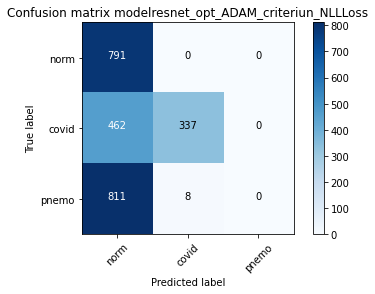

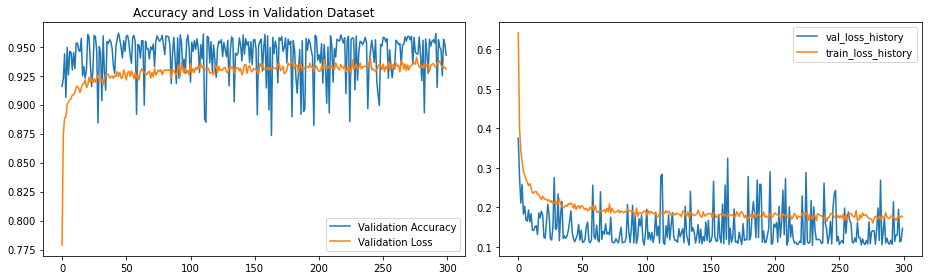


==== END ====
[[786   0   5]
 [  1 754  44]
 [  3  39 777]]

Sensitivity or recall total
0.9618098796180988

Sensitivity or recall per classes
[0.99 0.94 0.95]

Precision
[0.99 0.95 0.94]

F1 Score
[0.99 0.95 0.94]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> resnet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 3
criteriun -> 2

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -28.5806 Acc: 0.3772
val Loss: -51.9439 Acc: 0.4824

Epoch 1/299
----------
train Loss: -77.0796 Acc: 0.5116
val Loss: -99.4243 Acc: 0.5629

Epoch 2/299
----------
train Loss: -125.3141 Acc: 0.5973
val Loss: -145.0000 Acc: 0.4247

Epoch 3/299
----------
train Loss: -173.5396 Acc: 0.5260
val Loss: -193.5031 Acc: 0.4292

Epoch 4/299
----------
train Loss: -221.8833 Acc: 0.5035
val Loss: -243.3299 Acc: 0.5662

Epoch 5/299
----------
train Loss: -270.3469 Acc: 0.4875
val Loss: -287

train Loss: -4040.2306 Acc: 0.4277
val Loss: -4058.5469 Acc: 0.4301

Epoch 84/299
----------
train Loss: -4089.1016 Acc: 0.4314
val Loss: -4064.9015 Acc: 0.4159

Epoch 85/299
----------
train Loss: -4137.4837 Acc: 0.4283
val Loss: -4082.8835 Acc: 0.4288

Epoch 86/299
----------
train Loss: -4185.4793 Acc: 0.4283
val Loss: -4141.5036 Acc: 0.4002

Epoch 87/299
----------
train Loss: -4233.9639 Acc: 0.4285
val Loss: -4326.8852 Acc: 0.4749

Epoch 88/299
----------
train Loss: -4282.2863 Acc: 0.4255
val Loss: -4306.5947 Acc: 0.4226

Epoch 89/299
----------
train Loss: -4330.5815 Acc: 0.4268
val Loss: -4257.1257 Acc: 0.4703

Epoch 90/299
----------
train Loss: -4378.4645 Acc: 0.4240
val Loss: -4325.7401 Acc: 0.4500

Epoch 91/299
----------
train Loss: -4427.6001 Acc: 0.4241
val Loss: -4438.6018 Acc: 0.4591

Epoch 92/299
----------
train Loss: -4475.3734 Acc: 0.4254
val Loss: -4414.0734 Acc: 0.3977

Epoch 93/299
----------
train Loss: -4524.2523 Acc: 0.4283
val Loss: -4411.3909 Acc: 0.4180

E

val Loss: -8078.2072 Acc: 0.4703

Epoch 171/299
----------
train Loss: -8292.6601 Acc: 0.4358
val Loss: -8182.2537 Acc: 0.4479

Epoch 172/299
----------
train Loss: -8342.1727 Acc: 0.4350
val Loss: -8053.6571 Acc: 0.4724

Epoch 173/299
----------
train Loss: -8390.5959 Acc: 0.4337
val Loss: -8308.0499 Acc: 0.4575

Epoch 174/299
----------
train Loss: -8437.8341 Acc: 0.4340
val Loss: -8287.3413 Acc: 0.4720

Epoch 175/299
----------
train Loss: -8486.0617 Acc: 0.4346
val Loss: -8348.8872 Acc: 0.4566

Epoch 176/299
----------
train Loss: -8534.4264 Acc: 0.4310
val Loss: -8523.6262 Acc: 0.4072

Epoch 177/299
----------
train Loss: -8583.4214 Acc: 0.4299
val Loss: -8434.5445 Acc: 0.4213

Epoch 178/299
----------
train Loss: -8631.4148 Acc: 0.4351
val Loss: -8458.7076 Acc: 0.4691

Epoch 179/299
----------
train Loss: -8680.8285 Acc: 0.4345
val Loss: -8543.5771 Acc: 0.4130

Epoch 180/299
----------
train Loss: -8729.3233 Acc: 0.4357
val Loss: -8695.7746 Acc: 0.4164

Epoch 181/299
----------
t

train Loss: -12449.0738 Acc: 0.4267
val Loss: -12305.1427 Acc: 0.4035

Epoch 258/299
----------
train Loss: -12498.7457 Acc: 0.4234
val Loss: -12574.0552 Acc: 0.4462

Epoch 259/299
----------
train Loss: -12546.2961 Acc: 0.4262
val Loss: -12244.1676 Acc: 0.4188

Epoch 260/299
----------
train Loss: -12595.5089 Acc: 0.4235
val Loss: -12549.6151 Acc: 0.4778

Epoch 261/299
----------
train Loss: -12643.2085 Acc: 0.4265
val Loss: -12595.6990 Acc: 0.4159

Epoch 262/299
----------
train Loss: -12692.4138 Acc: 0.4247
val Loss: -12901.1894 Acc: 0.4400

Epoch 263/299
----------
train Loss: -12739.2873 Acc: 0.4241
val Loss: -12718.3073 Acc: 0.4512

Epoch 264/299
----------
train Loss: -12787.4948 Acc: 0.4224
val Loss: -12760.5141 Acc: 0.3757

Epoch 265/299
----------
train Loss: -12835.9215 Acc: 0.4256
val Loss: -12636.2901 Acc: 0.3740

Epoch 266/299
----------
train Loss: -12884.2583 Acc: 0.4248
val Loss: -12518.8647 Acc: 0.4081

Epoch 267/299
----------
train Loss: -12931.7017 Acc: 0.4245
val 

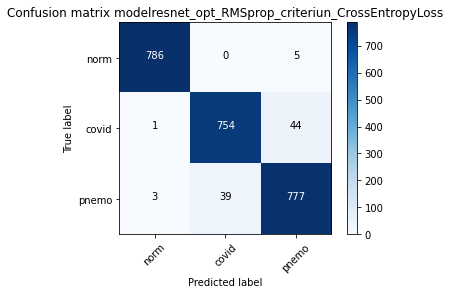

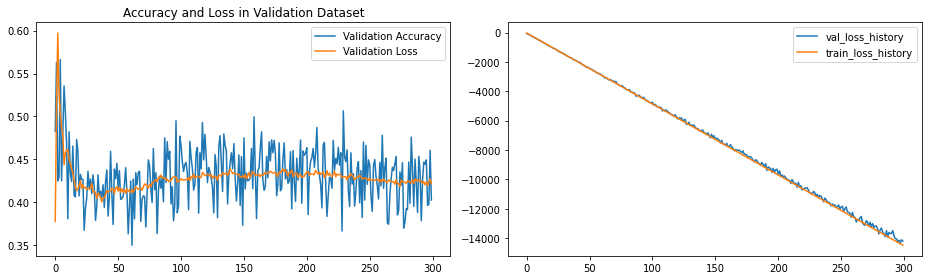


==== END ====
[[791   0   0]
 [230 569   0]
 [744  71   4]]

Sensitivity or recall total
0.5662100456621004

Sensitivity or recall per classes
[1.   0.71 0.  ]

Precision
[0.45 0.89 1.  ]

F1 Score
[0.62 0.79 0.01]
Confusion matrix, without normalization


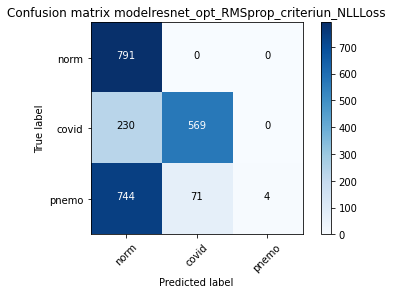

In [11]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
num_classes = 3

_models = ['resnet'] #['squeezenet', 'densenet', 'resnet', 'alexnet', 'vgg']
lrs = [1e-4]
_epoch = [300]
batch_sizes = [8]
opt = [1, 2, 3]
crt = [1, 2]

for _model in _models:
    for _epochs in _epoch:
        for _lrs in lrs:
            for _batch in batch_sizes:
                for _opt in opt:
                    for _crt in crt:
                               
                        print()
                        print('='*60)
                        print('==== INITIALIZING WITH PARAMETERS: ====')
                        print(f'model -> {_model}')
                        print(f'epochs -> {_epochs}')
                        print(f'lr -> {_lrs}')
                        print(f'batch size -> {_batch}')
                        print(f'optimizer -> {_opt}')
                        print(f'criteriun -> {_crt}')
                        print()

                        feature_extract = True

                        model_ft, input_size = initialize_model(_model, num_classes, 
                                                                feature_extract, use_pretrained=True)

                        # Send the model to GPU
                        model_ft = model_ft.to(device)

                        print('-'*20)
                        params_to_update = model_ft.parameters()
                        print("Params to learn:")
                        if feature_extract:
                            params_to_update = []
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    params_to_update.append(param)
                                    print("\t",name)

                        else:
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    print("\t",name)


                        print()
                        print('-'*20)
                        print()
                        print('== Epochs ==')

                        if _opt == 1:
                            optimizer_ft = optim.SGD(params_to_update, _lrs, momentum=0.9)
                            opt_name = 'SGD'

                        if _opt == 2:
                            optimizer_ft = optim.Adam(params_to_update, _lrs)
                            opt_name = 'ADAM'
                            
                        if _opt == 3:
                            optimizer_ft = optim.RMSprop(params_to_update, _lrs)
                            opt_name = 'RMSprop'


                        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

                        #tray nn.NLLLoss
                        if _crt == 1:
                            criterion = nn.CrossEntropyLoss()
                            crt_name = 'CrossEntropyLoss'
                        if _crt == 2:
                            criterion = nn.NLLLoss()
                            crt_name = 'NLLLoss'

                        model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft,
                                                num_epochs=_epochs, model_name=_model, lr=_lrs,
                                                batch_size=_batch, opt_name=opt_name, crt_name=crt_name)

                        from sklearn.metrics import confusion_matrix

                        nb_classes = 3

                        # Initialize the prediction and label lists(tensors)
                        predlist=torch.zeros(0,dtype=torch.long, device='cpu')
                        lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

                        with torch.no_grad():
                            for i, (inputs, classes) in enumerate(dataloaders['val']):
                                inputs = inputs.to(device) #labels atuais
                                classes = classes.to(device) #classes
                                outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
                                _, preds = torch.max(outputs, 1) #pega o maior valor das predições

                                # Append batch prediction results
                                predlist=torch.cat([predlist,preds.view(-1).cpu()])
                                lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

                        # Confusion matrix
                        conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
                        print(conf_mat)
                        print()

                        from sklearn import metrics

                        #analise dos resultados do modelo
                        print('Sensitivity or recall total')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

                        print()
                        print('Sensitivity or recall per classes')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('Precision')
                        print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('F1 Score')
                        print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))

                        cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
                        np.set_printoptions(precision=2)

                        plt.figure()

                        plot_confusion_matrix(cm, classes=['norm', 'covid', 'pnemo'], 
                        title='Confusion matrix model'+_model+'_opt_'+opt_name+'_criteriun_'+crt_name)




Os resultados na matriz de confuzão e scores estão ruins, provavelmente pelo param.requires_grad = True 

Testar depois com False

**Peguei o código original**

In [ ]:
print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
########## CAM try 1

In [ ]:
# # hook the feature extractor
# features_blobs = []
# def hook_feature(module, input, output):
#     features_blobs.append(output.data.cpu().numpy())

# model_ft._modules.get(finalconv_name).register_forward_hook(hook_feature)

# # get the softmax weight
# params = list(model_ft.parameters())
# weight_softmax = np.squeeze(params[-2].data.numpy())

# def returnCAM(feature_conv, weight_softmax, class_idx):
#     # generate the class activation maps upsample to 256x256
#     size_upsample = (256, 256)
#     bz, nc, h, w = feature_conv.shape
#     output_cam = []
#     for idx in class_idx:
#         cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
#         cam = cam.reshape(h, w)
#         cam = cam - np.min(cam)
#         cam_img = cam / np.max(cam)
#         cam_img = np.uint8(255 * cam_img)
#         output_cam.append(cv2.resize(cam_img, size_upsample))
#     return output_cam


In [ ]:
# normalize = transforms.Normalize(
#    mean=[0.485, 0.456, 0.406],
#    std=[0.229, 0.224, 0.225]
# )
# preprocess = transforms.Compose([
#    transforms.Resize((224,224)),
#    transforms.ToTensor(),
#    normalize
# ])

# response = requests.get(IMG_URL)
# img_pil = Image.open(io.BytesIO(response.content))
# img_pil.save('test.jpg')

# img_tensor = preprocess(img_pil)
# img_variable = Variable(img_tensor.unsqueeze(0))
# logit = model_ft(img_variable)

# # download the imagenet category list
# # classes = {int(key):value for (key, value)
# #           in requests.get(LABELS_URL).json().items()}

# # h_x = F.softmax(logit, dim=1).data.squeeze()
# # probs, idx = h_x.sort(0, True)
# # probs = probs.numpy()
# # idx = idx.numpy()

# # # output the prediction
# # for i in range(0, 5):
# #     print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# # generate class activation mapping for the top1 prediction
# CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# # render the CAM and output
# # print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
# img = cv2.imread('test.jpg')
# height, width, _ = img.shape
# heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
# result = heatmap * 0.3 + img * 0.5
# cv2.imwrite('CAM.jpg', result)

In [ ]:
# import IPython.display as display
# from PIL import Image
# image_path = 'CAM.jpg'
# display.display(Image.open(image_path))

In [ ]:
########## CAM try 1 FIIMMMM

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.405])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(1)  # pause a bit so that plots are updated

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, (inputs, classes) in enumerate(dataloaders['test']):
        #inputs, labels = data

        #inputs, labels = Variable(inputs), Variable(labels)
        inputs = inputs.to(device) #labels atuais
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.figure(figsize=(20,20))
            ax = plt.subplot(5, 2, images_so_far)
            ax.axis('off')
            ax.set_title('{}'.format(class_names[predlist[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

#print(dir(model))
visualize_model(model_ft)

In [ ]:
# savePath = "test_model.pth"
# torch.save(model_ft.state_dict(), savePath)

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
#TRY CAM
#do it using RESNET

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import PIL
import scipy.ndimage as nd
from torch.autograd import Variable

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
transformers = {
    'train_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'valid_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

trans = ['train_transforms','valid_transforms','test_transforms']

path = "/home/jimi/dissertacao/covid19/datasets/80-20/"
categories = ['train','val','test']
dset = {x : torchvision.datasets.ImageFolder(path+x,
                                             transform=transformers[y]) for x,y in zip(categories, trans)}

dataset_sizes = ['train']


num_threads = 4 
dataloaders =  {x : torch.utils.data.DataLoader(dset[x], batch_size=16, shuffle=True, num_workers=num_threads)
               for x in categories}

dataset_sizes = {x : len(dset[x]) for x in ['train','val','test']}

class_names = dset['train'].classes

#class_names = image_datasets['train'].classes

# Detect if we have a GPU available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
##### RESNET
##Build model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet152(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features,3),
            nn.LogSoftmax(dim=1)
        )
        for params in self.model.parameters():
            params.requires_grad = True
        self.model.fc = self.classifier
        
    def forward(self, x):
        return self.model(x)
    
    def fit(self, dataloaders, num_epochs):
        train_on_gpu = torch.cuda.is_available()
        optimizer = optim.Adam(self.model.fc.parameters())
        scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
        criterion = nn.NLLLoss()
        since = time.time()
        
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        
        if train_on_gpu:
            self.model = self.model.cuda()
            
        for epoch in range(1, num_epochs+1):
            print("epoch {}/{}".format(epoch, num_epochs))
            print("-" * 10)
            
            for phase in ['train','val']:
                if phase == 'train':
                    scheduler.step()
                    self.model.train()
                else:
                    self.model.eval()
                
                running_loss = 0.0
                running_corrects = 0.0
                
                for inputs, labels in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print("{} loss:  {:.4f}  acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
                
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
        
        time_elapsed = time.time() - since
        print('time completed: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 600))
        print("best val acc: {:.4f}".format(best_acc))
        
        self.model.load_state_dict(best_model_wts)
        return self.model
    
model = Model()
model_ft = model.fit(dataloaders,300)

from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


from sklearn import metrics

#analise dos resultados do modelo
print('Sensitivity or recall total')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

print()
print('Sensitivity or recall per classes')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('Precision')
print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('F1 Score')
print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))




epoch 1/300
----------
train loss:  0.2861  acc: 0.8961
val loss:  0.1513  acc: 0.9481
epoch 2/300
----------
train loss:  0.1862  acc: 0.9335
val loss:  0.1124  acc: 0.9606
epoch 3/300
----------
train loss:  0.1733  acc: 0.9355
val loss:  0.1183  acc: 0.9597
epoch 4/300
----------
train loss:  0.1353  acc: 0.9514
val loss:  0.1139  acc: 0.9589
epoch 5/300
----------
train loss:  0.1371  acc: 0.9514
val loss:  0.1076  acc: 0.9618
epoch 6/300
----------
train loss:  0.1363  acc: 0.9499
val loss:  0.1058  acc: 0.9626
epoch 7/300
----------
train loss:  0.1365  acc: 0.9512
val loss:  0.1081  acc: 0.9606
epoch 8/300
----------


In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


In [ ]:
import itertools 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')





In [ ]:
cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
np.set_printoptions(precision=2)

plt.figure()

plot_confusion_matrix(cm, classes=['norm', 'covid', 'pnemo'], title='Confusion matrix')

In [ ]:
data_dir_test = "/home/jimi/dissertacao/covid19/datasets/80-20/test/"

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

In [ ]:
model_ft.eval()

In [ ]:
#print(model)

In [ ]:
#print(model_ft)

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir_test, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data,sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:
# plot predictions
to_pil = transforms.ToPILImage()
images, labels = get_random_images(30)
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    
    data = datasets.ImageFolder(data_dir_test, transform=test_transforms)
    classes = data.classes
    
    #print (f'index: {index}')
    #print (f'image: {image}')
    #print (f'labes: {labels}')
    #print (f'classes index :{classes[index]}')
    #print (f'classes 2:{classes}')
    
    sub = fig.add_subplot(8, 4, ii+1)
    
    #print()
    res = int(labels[ii]) == 1
    #print(f'int(labels[ii]): {int(labels[ii])}')
    #print(f'index: {index}')
    #print(f'res = int(labels[ii]) == index: {res}')
    #print()
    
    #print (f'res : {res}')
    
    sub.set_title(str(classes[1]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [ ]:
loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
def image_loader(image_name):
    image = PIL.Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = image.unsqueeze(0)
    return image

In [ ]:
class LayerActivations():
    features=[]
    def __init__(self,model):
        self.hooks = []
        self.hooks.append(model.layer4.register_forward_hook(self.hook_fn))
    def hook_fn(self,module,input,output):
        self.features.append(output)
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/1785.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/860.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/2480.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001.png'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001-9-a.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001-10.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
########## CAM try 2 FIIMMMM

In [ ]:
########## CAM try 2 FIIMMMM

In [22]:
########## CAM try 2 FIIMMMM

In [ ]:
########## CAM try 3 ref - https://github.com/ironWolf1990/pytorch-covid19

In [ ]:
########## CAM try 3 ref- https://github.com/ironWolf1990/pytorch-covid19

In [ ]:
########## CAM try 3 ref

In [ ]:
########## CAM try 3 ref- https://github.com/ironWolf1990/pytorch-covid19
########## CAM try 3 ref
########## CAM try 3 ref
########## CAM try 3 ref

In [ ]:
# utils.py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec
from sklearn.manifold import TSNE


def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        cmap = cm.get_cmap("rainbow")
        c = cmap(int(255 * s / 9))
        plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.show()
    plt.pause(0.01)

def data_viz(layer, label):
    # https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents-notebooks/401_CNN.ipynb
    tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(layer.data.numpy()[:plot_only, :])
    labels = label.numpy()[:plot_only]
    plot_with_labels(low_dim_embs, labels)


def plot_test_image_result(img, ps, le, cam=None):

    _ = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])

    if cam is not None:
        ax1.imshow(cam, alpha=0.6)
        ax1.imshow(img, alpha=0.4)
    else:
        ax1.imshow(img)

    ax2.barh(np.arange(len(ps)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(ps)))

    for i, v in enumerate(ps):
        ax2.text(
            .01,
            i-0.1,
            f'{v:.3f}',
            color='blue',
            fontweight='bold')

    if le is None:
        ax2.set_yticklabels(np.arange(len(ps)))
    else:
        ax2.set_yticklabels(le.inverse_transform(np.arange(len(ps))))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

In [ ]:
# makedataset.py

from os.path import isfile, join
from os import walk
import pandas as pd
import numpy as np
from itertools import tee

from sklearn.model_selection import train_test_split

if __name__ == "__main__":

    path = "./data"
    sample_per_category = 500
    seed = 24
    split_frac = 0.20

    df_raw = None

    genFiles = (
        (dirpath, dirnames, filenames) for (dirpath, dirnames, filenames) in walk(path)
    )

    files, genFiles = tee(genFiles)
    file_count = sum(len(f) for _, _, f in files)

    df_raw = pd.DataFrame(
        data=np.nan, index=np.arange(0, file_count - 1), columns=["LABEL", "FILE"]
    )

    files, genFiles = tee(genFiles)
    idx = 0
    for r, _, f in files:
        for _f in f:
            if isfile(join(r, _f)) and _f.endswith(
                (".jpeg", ".png", "jpg", ".JPEG", ".PNG", "JPG")
            ):
                path = "/".join((r, _f))
                *_, label = r.split("/")
                df_raw.iloc[idx] = [label, path]
                idx += 1

    df_raw.to_csv("./data/raw.csv", index=False)

    # # 3-class
    df_main = pd.DataFrame(
        data=np.nan,
        index=np.arange(0, sample_per_category * 3),
        columns=["FILE", "LABEL"],
    )

    df_main = df_raw.groupby("LABEL").apply(
        lambda s: s.sample(n=min(len(s), sample_per_category), random_state=seed)
    )

    train_df, test_df = train_test_split(
        df_main, random_state=seed, test_size=split_frac, shuffle=True
    )

    train_df.to_csv("./data/3_class_train_df.csv", index=False)
    test_df.to_csv("./data/3_class_test_df.csv", index=False)

    print(f"\n3_class_train_df:\n{train_df['LABEL'].value_counts()}")
    print(f"3_class_test_df:\n{test_df['LABEL'].value_counts()}")

    # 2-class
    df_main = pd.DataFrame(
        data=np.nan,
        index=np.arange(0, sample_per_category * 2),
        columns=["FILE", "LABEL"],
    )

    index = df_raw[df_raw["LABEL"] == "pneumonia"].index
    df_raw.drop(index, inplace=True)

    df_main = df_raw.groupby("LABEL").apply(
        lambda s: s.sample(n=min(len(s), sample_per_category), random_state=seed)
    )

    train_df, test_df = train_test_split(
        df_main, random_state=seed, test_size=split_frac, shuffle=True
    )

    train_df.to_csv("./data/2_class_train_df.csv", index=False)
    test_df.to_csv("./data/2_class_test_df.csv", index=False)

    print(f"\n2_class_train_df:\n{train_df['LABEL'].value_counts()}")
    print(f"2_class_test_df:\n{test_df['LABEL'].value_counts()}")

In [ ]:
# architectures.py

import torch.nn as nn
from torchvision.models import resnet50


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class Rn50(nn.Module):
    def __init__(self, device, train_base=False, classes=2):
        super(Rn50, self).__init__()

        self.device = device

        self.net_back = resnet50(pretrained=True).to(self.device)
        self._trainable(train_base)

        fc_size = self.net_back.fc.in_features
        self.net_back.fc = Identity()

        self.net_head = nn.Sequential(
            nn.Linear(in_features=fc_size, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=classes),
            nn.LogSoftmax(dim=1),
        ).to(self.device)

    def forward(self, x):
        x = self.net_back(x.to(self.device))
        x = x.view(x.size(0), -1)
        return self.net_head(x.to(self.device))

    def _trainable(self, flag):
        for param in self.net_back.parameters():
            param.requires_grad = flag


# old way
# modules = list(resnet50(pretrained=True).children())[:-1]
# self.net_back = nn.Sequential(*modules).to(self.device)
# fc_size = list(self.net_back.parameters())[-1].size(0)
# self.net_head = nn.Sequential(...).to(self.device)

In [ ]:
# activationmap.py

import torch


class FeatureBuffer():

    features=None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # self.features = ((output.cpu()).data).numpy()
        self.features = output

    def remove(self):
        self.hook.remove()


# def GradCam(model, input_image_tensor):

#     https://github.com/tyui592/class_activation_map/blob/master/cam.py
#     https://github.com/daixiangzi/Grad_Cam-pytorch-resnet50/blob/578db29d13b0e7d17aa53d9bac116674771618ec/test_grad_cam.py#L19
#     https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html
#     https://github.com/MarcoCBA/Class-Activation-Maps-PyTorch/blob/master/class_activation_maps.ipynb

#     print(model)

#     final_conv_layer = model.net_back._modules.get('layer4')
#     fc_layer = model.net_head._modules.get('0')
#     fb = FeatureBuffer(final_conv_layer)

#     model = model.eval()
#     out = model(input_image_tensor)

#      # based on model caluculate output!!!
#     probabilities = torch.exp(out)
#     _, predicted = torch.max(probabilities, 1)
#     feature_maps = fb.features

#     print("Output's shape: ", out.shape)
#     print("Feature maps's shape: ", feature_maps.shape)

#     weights_and_biases = list(fc_layer.parameters())
#     class_weights = weights_and_biases[0][predicted]
#     print("Weights's shape: ", weights_and_biases[0].shape)
#     print("Biases's shape: ", weights_and_biases[1].shape)
#     print("Class weights's shape :", class_weights.shape)

#     class_weights = class_weights.reshape((-1, 1, 1))
#     feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)
#     print("Class weights's shape :", class_weights.shape)
#     print("Feature maps's shape: ", feature_maps.shape)

#     class_activation_maps = np.array(torch.sum(feature_maps * class_weights, dim=0).detach(), dtype=np.float32)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(class_activation_maps)
#     plt.show()

#     resized_cam = cv2.resize(class_activation_maps, dsize=(224, 224), interpolation=cv2.INTER_LANCZOS4)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(resized_cam)
#     plt.show()

In [ ]:
# train.py

import math
from time import time
from copy import deepcopy

import torch

try:
    from torchsummary import summary
except:
    MODELSUMMARY = False
else:
    MODELSUMMARY = True

try:
    from sklearn.manifold import TSNE
except:
    VIZTSNE = False
else:
    VIZTSNE = True


def train_model(
    model,
    device,
    criterion,
    optimizer,
    dataloaders,
    dataloader_len,
    input_shape,
    scheduler=None,
    num_epochs=50,
):

    if MODELSUMMARY:
        summary(model, input_data=input_shape)

    start = time()
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        t_epoch = time()
        print(f"epoch: {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for idx, (labels, inputs) in enumerate(dataloaders[phase]):
                iter_batch = math.ceil(
                    dataloader_len[phase] / dataloaders[phase].batch_size
                )
                print(f"[phase: {phase}] batch: {idx+1}/{iter_batch}", end="\r")

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                if scheduler is not None:
                    scheduler.step()

            epoch_loss = running_loss / dataloader_len[phase]
            epoch_acc = running_corrects.double() / dataloader_len[phase]
            print(f"[phase: {phase}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                print(f"[saving model] epoch: {epoch+1} Acc: {epoch_acc:.4f}")
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())

        t_elapsed = time() - t_epoch
        print(f"epoch training complete in {t_elapsed//60:.0f}m {t_elapsed%60:.0f}s")
        print()

    time_elapsed = time() - start
    print(f"training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"best val Acc: {best_acc:4f}")

    model.load_state_dict(best_model_wts)

    checkpoint = {
        "input_shape": input_shape,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }

    torch.save(checkpoint, "./models/checkpoint.pth")
    return model

In [ ]:
# test.py

import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scripts.activationmap import FeatureBuffer
from sklearn.metrics import classification_report, confusion_matrix

#from .utils import plot_test_image_result


def test_model(model, testloader, device, encoder=None):

    correct = 0
    total = 0
    true_list = list()
    pred_list = list()

    for idx, (labels, inputs) in enumerate(testloader):
        iter_batch = math.ceil(len(testloader.dataset)/testloader.batch_size)
        print(f'[phase: test] batch: {idx+1}/{iter_batch}', end='\r')

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            probabilities = torch.exp(outputs)
            _, predicted = torch.max(probabilities, 1)

            total = idx + 1
            correct += torch.sum(predicted == labels.data)
            true_list.append((labels.data.cpu()).numpy().item())
            pred_list.append((predicted.cpu()).numpy().item())

    acc = 100*(correct.item()/total)
    print(f"[phase: test] total: {total}, correct: {correct}, acc: {acc:.3f}")

    print(classification_report(tuple(true_list), tuple(pred_list)))

    y_true = pd.Series(true_list, name='Actual')
    y_pred = pd.Series(pred_list, name='Predicted')
    cm = pd.crosstab(y_true, y_pred,  margins=True)

    print("confusion matrix")
    if encoder is not None:
        print({i : encoder.classes_[i] for i in range(0, len(encoder.classes_))})
    print(cm)



def test_image(model, image, in_shape, transform, device, labelencoder=None, cam=None):
    """
    GradCam
    """

    if cam is not None:
        final_conv_layer = model.net_back._modules.get('layer4')
        fc_layer = model.net_head._modules.get('0')
        fb = FeatureBuffer(final_conv_layer)

    input_tensor = transform(image).unsqueeze(0)
    inputs = input_tensor.to(device)

    model = model.eval()
    outputs = model(inputs)
    probabilities = torch.exp(outputs)
    prob = (probabilities.cpu()).detach().numpy().flatten()

    if cam is not None:
        _, predicted = torch.max(probabilities, 1)
        feature_maps = fb.features

        weights_and_biases = list(fc_layer.parameters())
        class_weights = weights_and_biases[0][predicted]

        class_weights = class_weights.reshape((-1, 1, 1))
        feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)

        class_activation_maps = np.array(
            torch.sum(feature_maps * class_weights, dim=0).cpu().detach(),
            dtype=np.float32)

        cam_map = cv2.resize(
            class_activation_maps,
            dsize=in_shape,
            interpolation=cv2.INTER_LANCZOS4)

    if cam is not None:
        plot_test_image_result(image.resize(in_shape), prob, labelencoder, cam_map)
    else:
        plot_test_image_result(image, prob, labelencoder)

In [ ]:
# evaluate.py 

import torch
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

import pandas as pd
from PIL import Image

from scripts.datagen import Datagen
from scripts.architectures import Rn50
from scripts.test import test_model, test_image


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    else:
        return "cpu"

test_file = "data/3_class_test_df.csv"
image_file = "data/raw/covid/covid_001.jpg"
num_workers = 2
batch_size = 1
input_shape = (256, 256)
le = LabelEncoder()

df = pd.read_csv(test_file)

test_transforms = transforms.Compose(
    [
        transforms.Resize(input_shape),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_set = Datagen(df, l_encoder=le, transforms=test_transforms)
label_enc = test_set.get_le()
device = get_device()

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, num_workers=num_workers,
)

model = Rn50(device=device, classes=3)
model.load_state_dict(torch.load("./models/checkpoint.pth")["state_dict"])

test_model(
    model=model,
    testloader=test_loader,
    device=device,
    encoder=label_enc)

input_image = Image.open(image_file).convert("RGB")
test_image(
    model=model,
    image=input_image,
    in_shape=input_shape,
    transform=test_transforms,
    device=device,
    labelencoder=label_enc,
    cam=True
)

In [ ]:
# datagen.py

from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image


class Datagen(Dataset):
    def __init__(self, dataframe, transforms=None, l_encoder=None):
        self.df = dataframe
        self.transforms = transforms
        self.encoder = l_encoder

        if self.encoder is not None:
            self.df["LABEL"] = self.encoder.fit_transform(self.df["LABEL"])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        label = self.df.iloc[idx, 0]
        image_file = self.df.iloc[idx, 1]
        image = Image.open(image_file).convert("RGB")

        if self.transforms:
            image = self.transforms(image)

        # print(image.shape)
        return (label, image)

    def get_le(self):
        return self.encoder

In [ ]:
# trainer.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd

from scripts.datagen import Datagen
from scripts.architectures import Rn50
from scripts.train import train_model


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    else:
        return "cpu"


train_file = "data/3_class_train_df.csv"
num_workers = 2
val_split = 0.2
batch_size = 32
num_epochs = 20
input_shape = (3, 256, 256)
le = LabelEncoder()

df = pd.read_csv(train_file)

train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

validation_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

train_set = Datagen(df, l_encoder=le, transforms=train_transforms)
validation_set = Datagen(df, l_encoder=le, transforms=validation_transforms)

train_idx, val_idx = train_test_split(list(range(len(df))), test_size=val_split)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(
    train_set,
    # shuffle=True,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers,
)

valid_loader = torch.utils.data.DataLoader(
    validation_set,
    # shuffle=False,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=num_workers,
)

device = get_device()
net = Rn50(device=device, classes=3)

dataloaders = {"train": train_loader, "val": valid_loader}
dataloader_len = {"train": len(train_idx), "val": len(val_idx)}

criteration = nn.NLLLoss()
optimizer = optim.Adam(net.parameters())
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(
    model=net,
    device=device,
    criterion=criteration,
    optimizer=optimizer,
    dataloaders=dataloaders,
    dataloader_len=dataloader_len,
    input_shape=input_shape,
    num_epochs=num_epochs,
)

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM
########## CAM try 3 FIM
########## CAM try 3 FIM
########## CAM try 3 FIM

In [ ]:
########## CAM functional

In [ ]:
# simple implementation of CAM in PyTorch for the networks such as ResNet, DenseNet, SqueezeNet, Inception

import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb

# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'https://diariodonordeste.verdesmares.com.br/image/contentid/policy:1.2966908:1594933666/ferramenta-sesa.jpg'

# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 1
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

#net.eval()

In [ ]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


In [ ]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')

img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable) ## aqui tem algo

# # download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# # output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)

In [ ]:
import IPython.display as display
from PIL import Image
image_path = 'CAM.jpg'
display.display(Image.open(image_path))

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")